In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
import pandas as pd

# 데이터 불러오기
data = pd.read_csv("/content/drive/MyDrive/Github/2025_Voicephishing/dataset/stt_results_train.csv")
spam_bt_fr = pd.read_csv("/content/drive/MyDrive/Github/2025_Voicephishing/dataset/stt_results_bt_fr.csv")
spam_bt_ge = pd.read_csv("/content/drive/MyDrive/Github/2025_Voicephishing/dataset/stt_results_bt_ge.csv")

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    56 non-null     object
 1   label   56 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


In [36]:
spam_bt_fr = spam_bt_fr.iloc[56:,:]
spam_bt_ge = spam_bt_ge.iloc[56:,:]
df = pd.concat([data, spam_bt_fr, spam_bt_ge]).reset_index(drop=True)

In [38]:
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    60 non-null     object
 1   label   60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [39]:
df.to_csv("/content/drive/MyDrive/Github/2025_Voicephishing/dataset/spam_stt_bt_all.csv", index=False)

In [19]:
# 라벨값이 1인 데이터만 추출
filtered = data[data["label"] == 1]
filtered

,text,label
2,Your Zenra account password is about to expir...,1
3,Immediate action required. Verify your identi...,1
6,We've noticed suspicious activity on your Zen...,1
10,Security update required. Verify your Xenra a...,1
13,Action required. Secure your Zenra account by...,1
14,You've received a refund of $500 from Zenra B...,1
15,Your Zenra account has been temporarily froze...,1
18,Your Zenra account is scheduled for closure. ...,1
19,Verify your identity to complete your pending...,1
20,A large sum of money was transferred from you...,1


In [5]:
!pip install -q openai sentence_transformers

In [ ]:
from openai import OpenAI
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# --- 1. 초기 설정 ---
client = OpenAI(api_key="")
MAX_WORKERS = 5  # 동시에 실행할 번역 작업 수 (API Rate Limit에 맞춰 조절)

# --- 2. 왕복 번역 함수 정의 ---
def translate_round_trip(text: str) -> tuple[str | None, str | None]:
    if not isinstance(text, str) or not text:
        return None, None

    try:
        # 단계 1: 영어 -> 한국어
        korean_response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a translator. Translate the given English text into French. Always provide the translation without any other explanations or refusals."},
                {"role": "user", "content": text}
            ],
            timeout=60
        )
        korean_text = korean_response.choices[0].message.content.strip()

        # 단계 2: 한국어 -> 영어
        english_response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a translator. Translate the given French text into English. Always provide the translation without any other explanations or refusals."},
                {"role": "user", "content": korean_text}
            ],
            timeout=60
        )
        retranslated_english_text = english_response.choices[0].message.content.strip()

        return korean_text, retranslated_english_text

    except Exception as e:
        print(f"Error during round-trip translation for '{text[:20]}...': {e}")
        return None, None

In [21]:
# --- 3. 병렬 실행 ---
texts_to_translate = filtered["text"].tolist()
# 결과를 저장할 두 개의 리스트를 미리 생성
translated_results = [None] * len(texts_to_translate)
english_results = [None] * len(texts_to_translate)

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    future_to_index = {
        executor.submit(translate_round_trip, text): i
        for i, text in enumerate(texts_to_translate)
    }

    for future in tqdm(as_completed(future_to_index), total=len(texts_to_translate), desc="왕복 번역 진행률"):
        original_index = future_to_index[future]
        try:
            # (한국어, 영어) 결과 튜플을 받아 각 리스트에 저장
            translated_res, english_res = future.result()
            translated_results[original_index] = translated_res
            english_results[original_index] = english_res
        except Exception as e:
            print(f"Task for index {original_index} generated an exception: {e}")

# --- 4. 결과 저장 ---
filtered['dialogue_translated'] = translated_results
filtered['dialogue_retranslated'] = english_results

왕복 번역 진행률: 100%|██████████| 26/26 [00:16<00:00,  1.60it/s]
/tmp/ipython-input-3726792403.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['dialogue_translated'] = translated_results
/tmp/ipython-input-3726792403.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['dialogue_retranslated'] = english_results


In [9]:
from sentence_transformers import SentenceTransformer, util

# 다국어 지원 모델 (한글 ↔ 영어 의미 비교에 적합)
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [22]:
# None 타입을 빈 문자열('')로 안전하게 대체
text_list = filtered["text"].fillna('').tolist()
dialogue_list = filtered["dialogue_retranslated"].fillna('').tolist()

# 임베딩 계산
embeddings_cleaned = model.encode(text_list, convert_to_tensor=True)
embeddings_english = model.encode(dialogue_list, convert_to_tensor=True)

# 코사인 유사도 계산
cosine_similarities = util.cos_sim(embeddings_cleaned, embeddings_english)

# 각 행별 유사도 값 저장
filtered["cosine_similarity"] = [cosine_similarities[i][i].item() for i in range(len(filtered))]

/tmp/ipython-input-1072931691.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["cosine_similarity"] = [cosine_similarities[i][i].item() for i in range(len(filtered))]


In [23]:
import pandas as pd
import re
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# --- 1. 재번역이 필요한 행 식별 (독일어 조건) ---
def is_japanese(text: str) -> bool:
    if not isinstance(text, str):
        return False
    # 히라가나, 가타카나, CJK 통합 한자(일반적인 한자) 범위
    return bool(re.search(r'[\u3040-\u30ff\u4e00-\u9fff]', text))

def is_korean(text: str) -> bool:
    if not isinstance(text, str):
        return False
    # 한글 유니코드 범위: 가~힣 (\uac00-\ud7af)
    return bool(re.search(r'[\uac00-\ud7af]', text))

def is_chinese(text: str) -> bool:
    if not isinstance(text, str):
        return False
    # CJK 통합 한자(일반적인 한자) 유니코드 범위: \u4e00-\u9fff
    return bool(re.search(r'[\u4e00-\u9fff]', text))

def is_english(text: str) -> bool:
    if not isinstance(text, str):
        return False
    # English letters (A-Z, a-z) range
    return bool(re.search(r'[a-zA-Z]', text))

def is_german(text: str) -> bool:
    """독일어 고유 문자(움라우트, 에스체트) 감지"""
    if not isinstance(text, str):
        return False
    # ä, ö, ü, Ä, Ö, Ü, ß
    return bool(re.search(r'[\u00e4\u00f6\u00fc\u00c4\u00d6\u00dc\u00df]', text))

def is_french(text: str) -> bool:
    """프랑스어 고유 문자(악센트, 세디유 등) 감지"""
    if not isinstance(text, str):
        return False
    # à, â, ç, è, é, ê, î, ô, ù, û, œ 등
    return bool(re.search(
        r'[\u00e0\u00e2\u00e7\u00e8\u00e9\u00ea\u00ee\u00f4\u0153\u00f9\u00fb'  # lowercase
        r'\u00c0\u00c2\u00c7\u00c8\u00c9\u00ca\u00ce\u00d4\u0152\u00d9\u00db]', # uppercase
        text
    ))

# 조건 1: 역번역 결과에 일본어가 포함된 경우
is_japanese_mask = filtered['dialogue_retranslated'].apply(is_french)

# 각 행별 유사도 값 저장
filtered["cosine_similarity"] = [cosine_similarities[i][i].item() for i in range(len(filtered))]

# 조건 2: 코사인 유사도 점수가 0.7 미만인 경우
low_similarity_mask = filtered['cosine_similarity'] < 0.7

# 두 조건 중 하나라도 True이면 재번역 대상으로 선정
retry_mask = is_japanese_mask | low_similarity_mask
# retry_mask = low_similarity_mask

# 재번역 대상과 정상 데이터로 DataFrame 분리
correct_df = filtered[~retry_mask]
retry_df = filtered[retry_mask].copy()

print(f"총 {len(filtered)}개 행 중 {len(retry_df)}개 행에 대한 재번역이 필요합니다.")
print(f"(사유: 한국어 포함 {is_japanese_mask.sum()}건, 유사도 미달 {low_similarity_mask.sum()}건)")

총 26개 행 중 0개 행에 대한 재번역이 필요합니다.
(사유: 한국어 포함 0건, 유사도 미달 0건)


/tmp/ipython-input-3925274585.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["cosine_similarity"] = [cosine_similarities[i][i].item() for i in range(len(filtered))]


In [29]:
# --- 2. 재번역 대상에 대해 병렬 처리 실행 ---
if not retry_df.empty:
    texts_to_retry = retry_df["text"].tolist()
    translated_results_retry = [None] * len(texts_to_retry)
    english_results_retry = [None] * len(texts_to_retry)

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        future_to_index = {
            executor.submit(translate_round_trip, text): i
            for i, text in enumerate(texts_to_retry)
        }
        for future in tqdm(as_completed(future_to_index), total=len(texts_to_retry), desc="오류 수정 재번역"):
            original_index = future_to_index[future]
            try:
                translated_res, english_res = future.result()
                translated_results_retry[original_index] = translated_res
                english_results_retry[original_index] = english_res
            except Exception as e:
                print(f"재번역 중 오류 발생 (인덱스 {original_index}): {e}")

    # 재번역 결과를 retry_df에 업데이트
    retry_df['dialogue_translated'] = translated_results_retry
    retry_df['dialogue_retranslated'] = english_results_retry

    # --- 3. 두 DataFrame을 다시 하나로 합치기 ---
    final_df = pd.concat([correct_df, retry_df], ignore_index=True)
    print("\n✅ 모든 재번역 작업을 완료하고 데이터를 병합했습니다.")

else:
    print("\n✅ 모든 행이 조건을 만족합니다. 추가 작업이 필요 없습니다.")
    final_df = filtered.copy()

# 최종 결과 확인
print(f"최종 DataFrame 크기: {final_df.shape}")


✅ 모든 행이 조건을 만족합니다. 추가 작업이 필요 없습니다.
최종 DataFrame 크기: (26, 5)


In [31]:
final_df = final_df[(final_df.cosine_similarity > 0.7) & (final_df.cosine_similarity < 0.96)]
final_df = final_df[['dialogue_retranslated', 'label']]
final_df.columns = ['text', 'label']
augmented_df = pd.concat([data, final_df], ignore_index=True)

In [33]:
augmented_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    58 non-null     object
 1   label   58 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


In [34]:
augmented_df.to_csv('/content/drive/MyDrive/Github/2025_Voicephishing/dataset/spam_stt_bt_fr.csv', index=False)

In [ ]:
from google.colab import runtime
runtime.unassign()

<Axes: ylabel='cosine_similarity'>

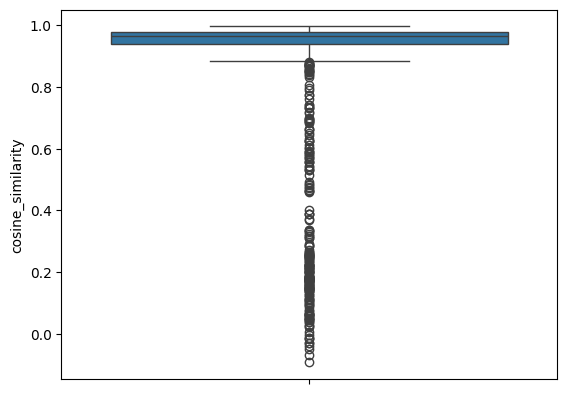

In [ ]:
pd.set_option('display.max_colwidth', 0)

import seaborn as sns

sns.boxplot(filtered.cosine_similarity)